In [1]:
import sys
sys.path.append('..')
import os.path
import copy
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple

%matplotlib inline

from scripts import ab_test, plotting_functions, perform_ab

DATA_DIR = os.path.join('..', 'data')

In [2]:
#Read in files
enrolled_baseline = pd.read_csv(os.path.join(DATA_DIR, 'Feb_enrolled_at_baseline.csv'), 
                                dtype = {'EMPLID': str})
not_enrolled_baseline = pd.read_csv(os.path.join(DATA_DIR, 'Feb_not_enrolled_at_baseline.csv'), 
                                    dtype = {'EMPLID': str})

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (24,25,29,30,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,17,19,20,23,28,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Sensitivity Tests

## For employees who were enrolled but contributed nothing at baseline, how many of them increased contributions?

In [3]:
#New df for folks whose alternate enrollment == False
contribute_0_0122 = enrolled_baseline[enrolled_baseline.alt_enrolled_0122 == False].copy()
contribute_0_0218 = enrolled_baseline[enrolled_baseline.alt_enrolled_0218 == False].copy()

print('How many employees contributed nothing, but were considered enrolled?', len(contribute_0_0122))
print()
print('How many of them increased contributions?')
print(contribute_0_0122.increased.value_counts())

How many employees contributed nothing, but were considered enrolled? 688

How many of them increased contributions?
False    659
True      29
Name: increased, dtype: int64


### If we consider them unenrolled, what do our results look like?

In [4]:
# Replace enrollment info with alternate enrollment info. 
# Doing it this way because our original 'not enrolled baseline' doesn't have alternate enrollment inrformation
contribute_0_0122['enrolled_0122'] = contribute_0_0122['alt_enrolled_0122']
contribute_0_0122['enrolled_0218'] = contribute_0_0122['alt_enrolled_0218']

#Append these people to the not_enrolled df
not_enrolled_baseline = \
    not_enrolled_baseline.append(contribute_0_0122.iloc[:,: (contribute_0_0122.columns.get_loc('newly_enrolled'))])

#Update enrollment information so that new folks' enrollment info is updated
not_enrolled_baseline['newly_enrolled'] = \
    (not_enrolled_baseline.enrolled_0122 == False) & (not_enrolled_baseline.enrolled_0218)

print(pd.crosstab(not_enrolled_baseline['treatment_real'], not_enrolled_baseline['newly_enrolled']))

newly_enrolled  False  True 
treatment_real              
0.0              6094     10
1.0              6098     13
2.0              6074      6


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


#### For RQ1:

Number in control group: 6104
Number in treatment group: 12191

Total successes, control: 10
Total successes, treatment: 19

Conversion Rate:
Control Group Rate:0.164%
Treatment Group Rate:0.156%
Percent change:-4.868%

Degree of certainty: 0.417



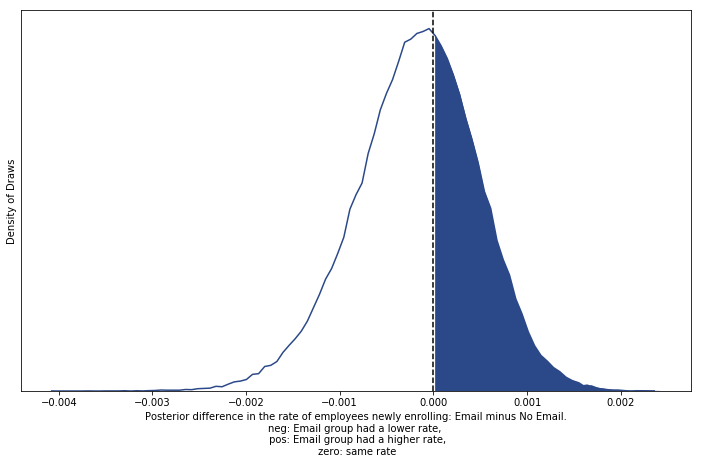

In [5]:
control, treatment = perform_ab.split_only2_groups(not_enrolled_baseline)

posterior, successes_a = perform_ab.perform_ab_test(control_df=control, 
                                                         treatment_df=treatment, 
                                                         column_of_interest='newly_enrolled')

perform_ab.plot_abtest(posterior, successes_a, "newly enrolling", "No Email", "Email")

#### For RQ2:

Number in control group: 6080
Number in treatment group: 6111

Total successes, control: 6
Total successes, treatment: 13

Conversion Rate:
Control Group Rate:0.099%
Treatment Group Rate:0.213%
Percent change:115.568%

Degree of certainty: 0.941



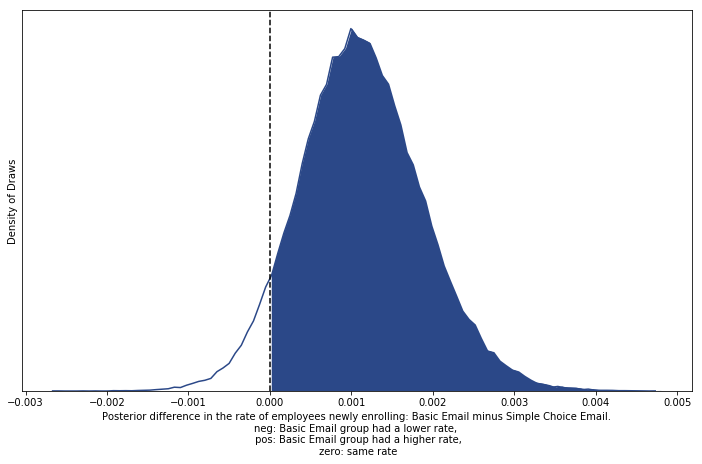

In [6]:
control, basic, choice = perform_ab.split_groups(not_enrolled_baseline)

posterior, successes_a = perform_ab.perform_ab_test(control_df=choice, 
                                                         treatment_df=basic, 
                                                         column_of_interest='newly_enrolled')

perform_ab.plot_abtest(posterior, successes_a, "newly enrolling", "Simple Choice Email", "Basic Email")

# How many people decreased contributions?

In [7]:
enrolled_baseline['decreased_annual'] = enrolled_baseline.ANNUAL_FLAT_AMT_0218 < enrolled_baseline.ANNUAL_FLAT_AMT_0122
pd.crosstab(enrolled_baseline.treatment_real, enrolled_baseline.decreased_annual)

decreased_annual,False,True
treatment_real,,
0.0,4580,47
1.0,4559,42
2.0,4593,34


#### For RQ1:

Number in control group: 4627
Number in treatment group: 9228

Total successes, control: 47
Total successes, treatment: 76

Conversion Rate:
Control Group Rate:1.016%
Treatment Group Rate:0.8240000000000001%
Percent change:-18.921%

Degree of certainty: 0.123



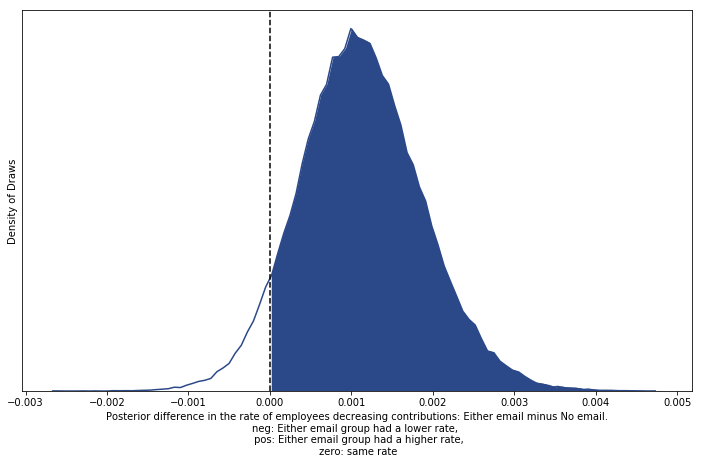

In [8]:
control, treatment = perform_ab.split_only2_groups(enrolled_baseline)

perform_ab.posterior, successes_a = perform_ab.perform_ab_test(control_df=control, 
                                                         treatment_df=treatment,
                                                         column_of_interest='decreased_annual')


perform_ab.plot_abtest(posterior, successes_a, 'decreasing contributions', 'No email', 'Either email')

#### For RQ2:

Number in control group: 4627
Number in treatment group: 4601

Total successes, control: 34
Total successes, treatment: 42

Conversion Rate:
Control Group Rate:0.735%
Treatment Group Rate:0.9129999999999999%
Percent change:24.227%

Degree of certainty: 0.826



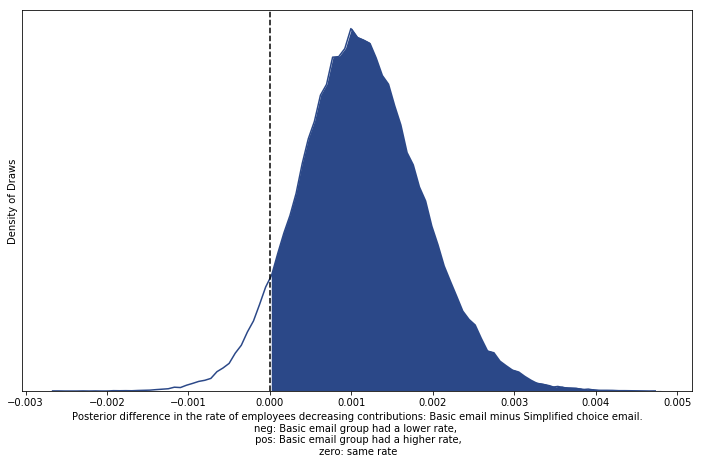

In [9]:
control, basic, choice = perform_ab.split_groups(enrolled_baseline)

perform_ab.posterior, successes_a = perform_ab.perform_ab_test(control_df=choice, 
                                                        treatment_df=basic,
                                                        column_of_interest='decreased_annual')
perform_ab.plot_abtest(posterior, successes_a, 'decreasing contributions', 'Simplified choice email', 'Basic email')